In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm

import nltk

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score

import dask
import multiprocessing
from joblib import delayed, Parallel, parallel_backend

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [4]:
cores = multiprocessing.cpu_count()

In [5]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_tweets=train_data['tweets'].tolist()
test_tweets=test_data['tweets'].tolist()

def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['tweets'] == i ].index, inplace=True)
    return df

train_data=keep_uniques(train_tweets, train_data)
test_data=keep_uniques(test_tweets, test_data)

In [6]:
len(train_data['tweets'].unique())

54618

In [7]:
len(test_data['tweets'].unique())

7861

In [8]:
train_data.describe().T

,count,unique,top,freq
tweets,54618,54618,#sarcasm for #people who don't understand #diy...,1
class,54618,4,regular,18557


In [9]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)
train_data['class'].value_counts()

regular       18557
sarcasm       15404
irony         12784
figurative     7873
Name: class, dtype: int64

In [10]:
temp=train_data.loc[train_data['class'] == 'regular']
lis=temp['tweets'].tolist()

import random
reg_del=[]
visited=set()
for _ in range(3600):
    n=random.randint(0,18556)
    if n not in visited:
        reg_del.append(lis[n])   
        
for i in reg_del:
    train_data.drop( train_data[ train_data['tweets'] == i ].index, inplace=True)
    
train_data['class'].value_counts()

sarcasm       15404
regular       15288
irony         12784
figurative     7873
Name: class, dtype: int64

In [11]:
test_data['class'].value_counts()

sarcasm       2054
irony         2029
figurative    1911
regular       1859
Name: class, dtype: int64

In [12]:
test_data = test_data.dropna()

In [13]:
def clean(tweet): 
    
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    return tweet

In [14]:
train_data['cleaned_text']= train_data['tweets'].apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweets'].apply((lambda x: clean(x)))
print("Cleaned")

Cleaned


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

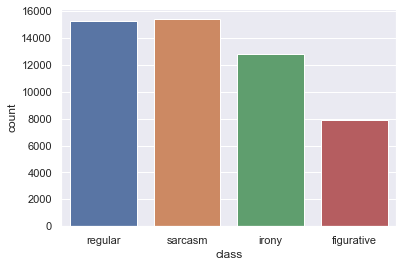

In [15]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['class'])

In [16]:
train_data.head()

,tweets,class,cleaned_text
43612,@irishexaminer \nWhoo hoo let's encourage this...,regular,whoo hoo let us encourage divide conquer fineg...
76286,"When u write a joke on #narendramodi , always ...",sarcasm,u write joke narendramodi always add sarcasm j...
51606,#diet #food #yummy #drugs #Pain #natural http:...,regular,diet food yummy drugs pain natural ancient peo...
64186,That glass ceiling though.... #thisiswhyweneed...,sarcasm,glass ceiling though thisiswhyweneedfeminism e...
39559,Tick--tock..Talibeard your time is nigh!! #Fas...,irony,ticktocktalibeard time nigh fashionpolice over...


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='class', ylabel='count'>

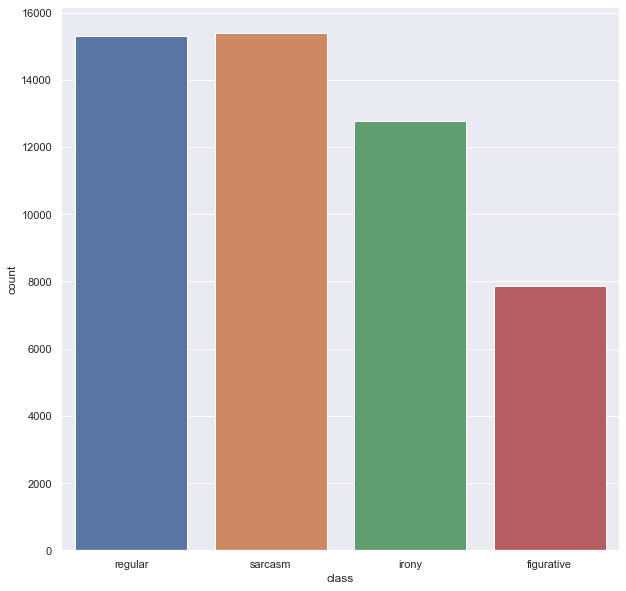

In [17]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['class'])

Text(0.5, 1.0, 'Figurative Tweets')

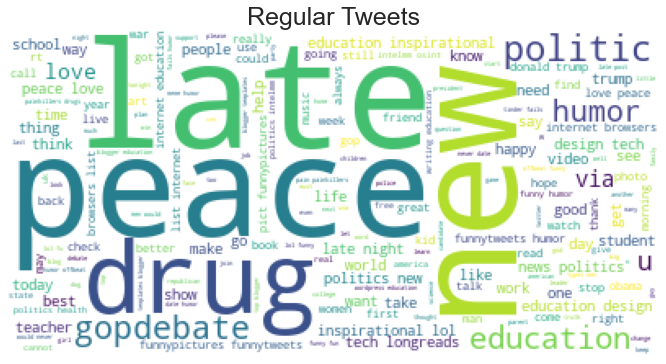

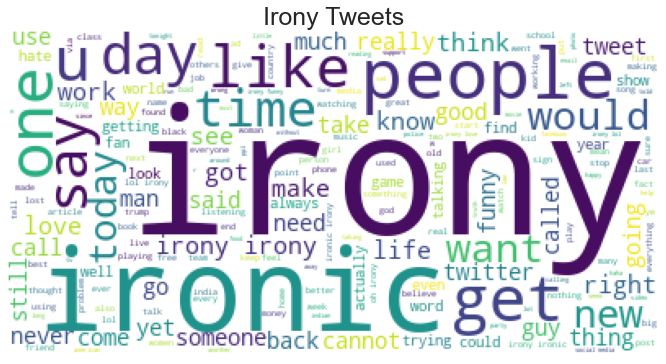

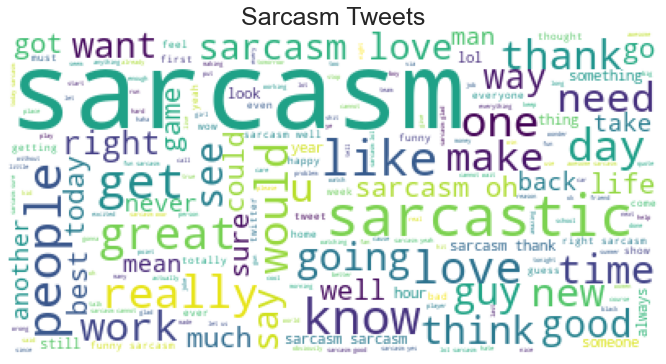

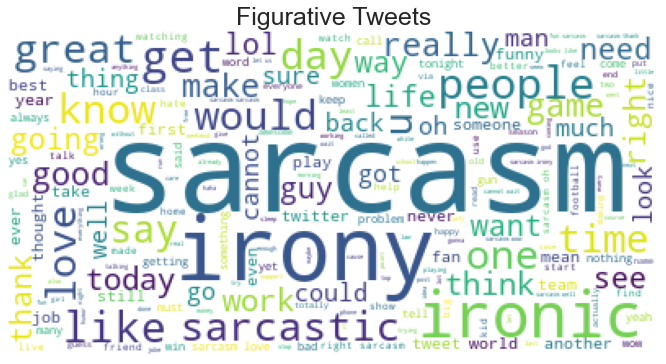

In [18]:
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='regular'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='irony'])
wc1 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc1)
plt.axis('off')
plt.title('Irony Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='sarcasm'])
wc2 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc2)
plt.axis('off')
plt.title('Sarcasm Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='figurative'])
wc3 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc3)
plt.axis('off')
plt.title('Figurative Tweets',fontsize=25)

In [19]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'irony':0,
        'sarcasm':1,
        'regular':2,
        'figurative':3
    }
    return class_dict[t_class]

In [20]:
train_data["target"] = train_data['class'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['class'].apply(lambda x: encode_target(x))

In [21]:
train = train_data[['cleaned_text','target']]
train.columns = ['text','labels']

test = test_data[['cleaned_text','target']]
test.columns = ['text','labels']
train.head()

,text,labels
43612,whoo hoo let us encourage divide conquer fineg...,2
76286,u write joke narendramodi always add sarcasm j...,1
51606,diet food yummy drugs pain natural ancient peo...,2
64186,glass ceiling though thisiswhyweneedfeminism e...,1
39559,ticktocktalibeard time nigh fashionpolice over...,0


In [22]:
test.head()

,text,labels
926,star wars fans protective franchises iconical ...,3
385,heard elsewhere india sarcasm like electricity...,3
594,ha ha think forgot include person replying … i...,3
3717,lol brett bielema whining buckeyes schedule ea...,0
1519,index great performance moved us bottom table ...,3


In [23]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

In [24]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

In [25]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

In [26]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

In [27]:
print("NAIVE BAYES CLASSIFIER")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))
# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 69.51% 
-> WordLevel TF-IDF Accuracy: 68.08999999999999%


In [28]:
print("LINEAR CLASSIFIER")
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))
# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR CLASSIFIER
-> Count Vectors Accuracy: 63.11% 
-> WordLevel TF-IDF Accuracy: 74.39%
-> Hash Vectors Accuracy: 75.0%


In [29]:
print("XGBOOST CLASSIFIER")
# Linear Classifier on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))
# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))
# Linear Classifier on Hash Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

XGBOOST CLASSIFIER
-> Count Vectors Accuracy: 75.4% 
-> WordLevel TF-IDF Accuracy: 75.17%
-> Hash Vectors Accuracy: 75.17%
